<a href="https://colab.research.google.com/github/acvats/Medical-Drugs--NLP/blob/master/Final_Analysis_with_ROS_balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing - Sentiment Analysis

####Connecting To kaggle and downloading dataset and also some important files

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/.kaggle"

In [2]:
!pip install kaggle

In [3]:
!mkdir .kaggle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cp '/content/drive/My Drive/kaggle auth key/kaggle.json' '/content/.kaggle/kaggle.json'

In [6]:
!chmod 600 /content/.kaggle/kaggle.json

In [7]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [8]:
!kaggle datasets list

ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
shivan118/healthcare-analytics                         AV : Healthcare Analytics                           2MB  2020-09-13 17:40:05           1635  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification        4MB  2020-09-08 11:40:11           1005  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           2076  
Cornell-University/arxiv                               arXiv Dataset                                     888MB  2020-09-22 15:33:49           3040  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND ETHNICITY (FACE DATA) CSV          

In [9]:
!kaggle datasets download -d 'arbazkhan971/analyticvidhyadatasetsentiment'

 74% 5.00M/6.72M [00:00<00:00, 28.8MB/s]
100% 6.72M/6.72M [00:00<00:00, 32.8MB/s]


In [10]:
cd {/content}/datasets/

/content/{/content}/datasets


In [11]:
cd arbazkhan971/analyticvidhyadatasetsentiment

/content/{/content}/datasets/arbazkhan971/analyticvidhyadatasetsentiment


In [12]:
!mkdir data

In [13]:
!unzip analyticvidhyadatasetsentiment.zip -d data

Archive:  analyticvidhyadatasetsentiment.zip
  inflating: data/sample_submission_i5xnIZD-1.csv  
  inflating: data/test_tOlRoBf.csv   
  inflating: data/train_F3WbcTw.csv  


In [14]:
cd data

/content/{/content}/datasets/arbazkhan971/analyticvidhyadatasetsentiment/data


In [15]:
cp '/content/drive/My Drive/Colab Notebooks/NLP-contractions/contractions.py' .

In [16]:
ls

contractions.py                  test_tOlRoBf.csv
sample_submission_i5xnIZD-1.csv  train_F3WbcTw.csv


# Natural Language Processing - Sentiment Analysis

### High Level Steps - 

<h6>1. Import all necessary libraries <br></h6>
2. Analyse the data<br>
3. Text - Preprocessing<br>
     a. Removing HTML tags<br>
     b. Removing accented characters<br>
     c. Resolving Contractions<br>
     d. Removing Special Characters & Extra Spaces <br>
     e. Changing the text data to lower case<br>
     f. Stemming <br>
     g. Lemmatization<br>
     h. Stop Word Removal<br>
    <br>
4. Data Balancing (ROS, random over sampling)<br>
5. Tokenization using TFIDF<br>
5. Train/Test Split<br>
6. Applying Models<br>
     a. Logistic Regression (Baseline Model)<br>
     b. Multinomial NB<br>
     c. Support Vector Classifiers<br>
7. Applying GRID SEARCH<br>
8. Reapplying based on the results from GRID SEARCH

#### Downloading NLTK (Stopwords) 

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
!pip install word2number
!pip install unidecode

  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5588 sha256=ac5ba1ad76fd652adad8a55d89ae646d3424330784b0e52905d34ada58f4b735
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number
     |████████████████████████████████| 245kB 4.5MB/s 


#### [1] Importing all the necessary Libraries

In [19]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
from nltk.tokenize.toktok import ToktokTokenizer
import spacy
import unidecode
from word2number import w2n
import gensim.downloader as api 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the downloaded language model
import en_core_web_sm 

%matplotlib inline

In [20]:
# Loading the languange models (Spacy - en_core_web_md-2.3.1)
nlp = en_core_web_sm.load()

# initializing the tokenizer, to use it later
tokenizer = ToktokTokenizer()

# removing no & not from STOPWORDS
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

#### [2] Analyzing the data

In [21]:
df = pd.read_csv('train_F3WbcTw.csv')

In [22]:
df.head(10)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1
5,a043780c757966243779bf3c0d11bf6eef721971,I can’t give you advice about Lemtrada because...,cladribine,2
6,be5a13376933a7f9bbf8e801c31691092f63260a,Reply posted for JessZidek. Hi Jess Sorry to r...,humira,0
7,08c3c0c702fc97d290204b37798ac62005da5626,Well as expected my Neurologist wants me to st...,gilenya,2
8,8fd3d7ad80791c9343e5cf8a83bd1adf6577d516,Why do you think that FIngolimod was such a mi...,fingolimod,1
9,793c5af7cc8332df17eb602247d886fbd1c80f89,Thank you so much…I’m learning a lot here at G...,tagrisso,2


In [23]:
df.shape

(5279, 4)

In [24]:
#Printing out all the columns in Dataset
df.columns.values.tolist()

['unique_hash', 'text', 'drug', 'sentiment']

In [25]:
# Getting rid of uniques hash values as they are no use to us
df.drop('unique_hash', axis=1, inplace=True)

In [26]:
df.head(10)

,text,drug,sentiment
0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,I can completely understand why you’d want to ...,gilenya,2
2,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,"Hi everybody, My latest MRI results for Brain ...",gilenya,1
5,I can’t give you advice about Lemtrada because...,cladribine,2
6,Reply posted for JessZidek. Hi Jess Sorry to r...,humira,0
7,Well as expected my Neurologist wants me to st...,gilenya,2
8,Why do you think that FIngolimod was such a mi...,fingolimod,1
9,Thank you so much…I’m learning a lot here at G...,tagrisso,2


In [27]:
df.shape

(5279, 3)

In [28]:
#Let's check diff kinds of sentiments
sentiment_list = list(df.sentiment.unique())
print(sentiment_list)

[2, 1, 0]


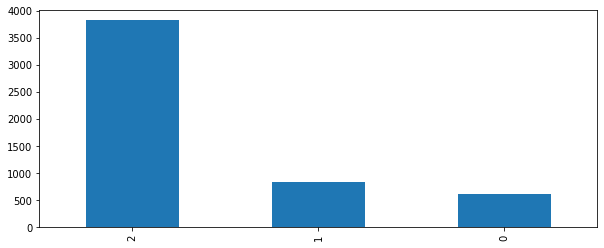

In [29]:
plt.figure(figsize=(10,4))
df.sentiment.value_counts().plot(kind='bar');

In [31]:
def print_plot(index):
    example = df[df.index == index][['text', 'drug','sentiment']].values[0]
    if len(example) > 0:
        print('Text:',example[0])
        print('Drug:', example[1])
        print('Sentiment:', example[2])

print_plot(5)

Text: I can’t give you advice about Lemtrada because I chose Cladribine. Have you thought about this drug? The doctors at Barts are keen to give it to people with SPMS. You can read about it here: http://multiple-sclerosis-research.blogspot.com/2016/01/suppose-there-was-therapy-for-all.html
Drug: cladribine
Sentiment: 2


In [32]:
print_plot(6)

Text: Reply posted for JessZidek. Hi Jess Sorry to read about the challenges you are having with your health. You mentioned a lot in your post. I just want to share some info on a few of the points. First, I know you said that you are scared of Humira. Humira and other biologics are very successful in reducing symptoms and inducing and maintain disease remission. To reduce your level of fear it can help to learn more about your treatment option. You can learn more about some of your treatment options. To learn more view our Understanding IBD Medication brochure at: http://www.crohnscolitisfoundation.org/assets/pdfs/understanding-ibd-meds-nov.pdf . If you would like to talk, contact the Help Center at 888-694-8872 or at info@crohnscolitisfoundation.org
Drug: humira
Sentiment: 0


### Text-Preprocessing

In [33]:
LINKS = re.compile('(www\.[\s]+)|(http?://[^\s]+)')

def clean_text(text):
    text = LINKS.sub('', text)
    text = ' '.join(word for word in text.split())
    return text

df['text'] = df['text'].apply(clean_text)   

In [34]:
print_plot(5)

Text: I can’t give you advice about Lemtrada because I chose Cladribine. Have you thought about this drug? The doctors at Barts are keen to give it to people with SPMS. You can read about it here:
Drug: cladribine
Sentiment: 2


In [35]:
print_plot(6)

Text: Reply posted for JessZidek. Hi Jess Sorry to read about the challenges you are having with your health. You mentioned a lot in your post. I just want to share some info on a few of the points. First, I know you said that you are scared of Humira. Humira and other biologics are very successful in reducing symptoms and inducing and maintain disease remission. To reduce your level of fear it can help to learn more about your treatment option. You can learn more about some of your treatment options. To learn more view our Understanding IBD Medication brochure at: . If you would like to talk, contact the Help Center at 888-694-8872 or at info@crohnscolitisfoundation.org
Drug: humira
Sentiment: 0


In [36]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [37]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
            
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
            
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
            
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
            
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
            
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
            
        # remove special characters and\or digits    
        if special_char_removal:
            
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits) 
            
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [38]:
# pre-process text and store the same
df['text'] = normalize_corpus(df['text'])

In [39]:
print_plot(5)

Text: not give advice lemtrada choose cladribine think drug doctor bart keen give people spms read
Drug: cladribine
Sentiment: 2


In [40]:
print_plot(6)

Text: reply post jesszidek hi jess sorry read challenge health mention lot post want share info point first know say scared humira humira biologic successful reduce symptom induce maintain disease remission reduce level fear help learn treatment option learn treatment option learn view understanding ibd medication brochure would like talk contact help center infocrohnscolitisfoundation org
Drug: humira
Sentiment: 0


In [41]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

1038088

In [42]:
print("Unique Values: " + str(len(df['text'].unique())))
print("Overall Values: " + str(len(df['text'])))
print("Difference: "+ str(len(df['text']) - len(df['text'].unique())))

Unique Values: 5176
Overall Values: 5279
Difference: 103


In [43]:
df.columns

Index(['text', 'drug', 'sentiment'], dtype='object')

### Balancing the Dataset (ROS)

Class 0: 617
Class 1: 837
Class 2: 3825


Text(0, 0.5, 'Number of Review')

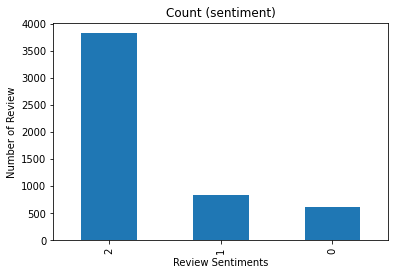

In [44]:
sentiment_count = df['sentiment'].value_counts()
print('Class 0:', sentiment_count[0])
print('Class 1:', sentiment_count[1])
print('Class 2:', sentiment_count[2])
sentiment_count.plot(kind='bar', title='Count (sentiment)');
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')

In [45]:
y= df['sentiment']

In [46]:
X= df.drop('sentiment', axis=1)
X = df.drop('drug', axis=1)

In [47]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
x_ros,y_ros = ros.fit_sample(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:
print(x_ros.shape)

(11475, 2)


In [49]:
print(y_ros.shape)

(11475,)


In [50]:
y_ros_df= pd.DataFrame({'sentiments': y_ros})

In [51]:
y_ros_df.shape

(11475, 1)

In [52]:
x_ros

array([['autoimmune disease tend come cluster gilenya feel good not think not change anything waste time energy take tysabri feel amazing no symptom dodgy color vision since always not know not know last month year decade decide enjoy ride no point worry',
        2],
       ['completely understand would want try result report lecture not always stand scrutiny peer review publication much still convincing hope work really aware happy risk great think important present balanced way understand not move straight first show promise animal study use drug human still lot animal datum gather human datum gather anyone tell safe effective not tell many time animal study not follow human one major attrition point drug development unpredictability issue cladribine gilenya interaction not predict people try doctor see pattern work go clemastine metformin exciting give say current condition personal risk tolerance make sense try definitely would not everyone',
        2],
       ['interesting targe

In [53]:
X_ros_df = pd.DataFrame({'text': x_ros[:, 0]})

In [54]:
X_ros_df.head

<bound method NDFrame.head of                                                     text
0      autoimmune disease tend come cluster gilenya f...
1      completely understand would want try result re...
2      interesting target sp receptor rather like fin...
3      interesting grand merci wonder lemtrada ocrevu...
4      hi everybody late mri result brain cervical co...
...                                                  ...
11470  interesting jihm year eylea one doctor tell no...
11471  hate know not seem work long good month go fas...
11472  look dr gs treatment pyramid ms inflammation n...
11473  hello everyone year year old year ago hemorrha...
11474  thank reply investigate drug bit follow medita...

[11475 rows x 1 columns]>

In [55]:
X_ros_df.shape

(11475, 1)

Class 0: 3825
Class 1: 3825
Class 2: 3825


Text(0, 0.5, 'Number of Review')

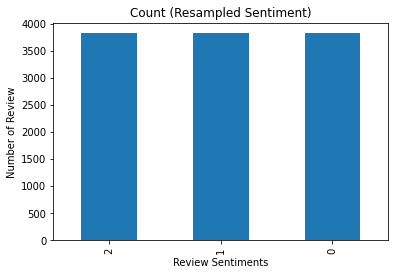

In [56]:
resampled_sentiment_count = y_ros_df.sentiments.value_counts()

print('Class 0:', resampled_sentiment_count[0])
print('Class 1:', resampled_sentiment_count[1])
print('Class 2:', resampled_sentiment_count[2])
resampled_sentiment_count.plot(kind='bar', title='Count (Resampled Sentiment)');
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')

In [57]:
tfidf = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfidf.fit(list(X_ros_df['text']))
text_tfidf =  tfidf.transform(X_ros_df['text'])

In [58]:
from sklearn.model_selection import train_test_split
(X_train_bal, X_test_bal, y_train_bal, y_test_bal) = train_test_split(text_tfidf, y_ros, test_size =.25, random_state =52)


In [59]:
print(X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape)

(8606, 32234) (2869, 32234) (8606,) (2869,)


### Loss Metrics Functions

In [60]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [61]:
from sklearn.metrics import confusion_matrix 

def CN(ytest, ypred):
  model_perforamnce = confusion_matrix(ytest, ypred)
  return model_perforamnce

In [62]:
from sklearn.metrics import classification_report 

def CR(ytest, ypred):
  classification = classification_report(ytest, ypred)
  return classification

In [63]:
from sklearn.metrics import accuracy_score

def acc(ytest, ypred):
  model_accuracy = accuracy_score(ytest, ypred)
  return model_accuracy

In [64]:
from sklearn.metrics import r2_score

def r2(ytest, ypred):
  r2s= r2_score(ytest, ypred)
  return r2s

In [65]:
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

y = np.random.randint(low=0, high=10, size=100)
y_p = np.random.randint(low=0, high=10, size=100)

def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=True, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax, cmap='coolwarm',vmin=0, vmax=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### [0] Baseline Model (Logistic Regression)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


confusion matrix :[[942  10  26]
 [ 13 838  67]
 [150 137 686]]
accuracy :0.85953293830603
classification report :              precision    recall  f1-score   support

           0       0.85      0.96      0.90       978
           1       0.85      0.91      0.88       918
           2       0.88      0.71      0.78       973

    accuracy                           0.86      2869
   macro avg       0.86      0.86      0.86      2869
weighted avg       0.86      0.86      0.86      2869

r2 score :0.5228066846821933


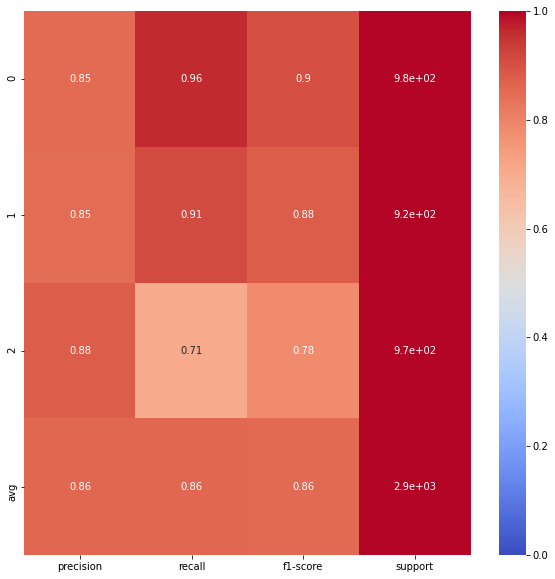

In [66]:
from sklearn.linear_model import LogisticRegression

# Fitting a simple Logistic Regression on TFIDF
clfLR = LogisticRegression(C=1.0)
clfLR.fit(X_train_bal, y_train_bal)
predictions = clfLR.predict(X_test_bal)

print("confusion matrix :"+str(CN(y_test_bal, predictions)))
print("accuracy :"+str(acc(y_test_bal, predictions)))
print("classification report :"+str(CR(y_test_bal, predictions)))
print("r2 score :"+str(r2(y_test_bal, predictions)))
plot_classification_report(y_test_bal, predictions)

In [67]:
predictionsLR = clfLR.predict_proba(X_test_bal)

print ("logloss: %0.3f " % multiclass_logloss(y_test_bal, predictionsLR))
print(predictionsLR.shape)
predictionsLR

logloss: 0.539 
(2869, 3)


array([[0.06755251, 0.79137496, 0.14107254],
       [0.14687182, 0.69783109, 0.15529708],
       [0.70600491, 0.1406676 , 0.15332749],
       ...,
       [0.12119967, 0.68167238, 0.19712795],
       [0.1224051 , 0.04074675, 0.83684815],
       [0.18960309, 0.12513714, 0.68525977]])

### [1] MultinomialNB

confusion matrix :[[781 145  52]
 [ 52 800  66]
 [230 294 449]]
accuracy :0.7075636110142907
classification report :              precision    recall  f1-score   support

           0       0.73      0.80      0.77       978
           1       0.65      0.87      0.74       918
           2       0.79      0.46      0.58       973

    accuracy                           0.71      2869
   macro avg       0.72      0.71      0.70      2869
weighted avg       0.73      0.71      0.70      2869

r2 score :0.13633648086949046


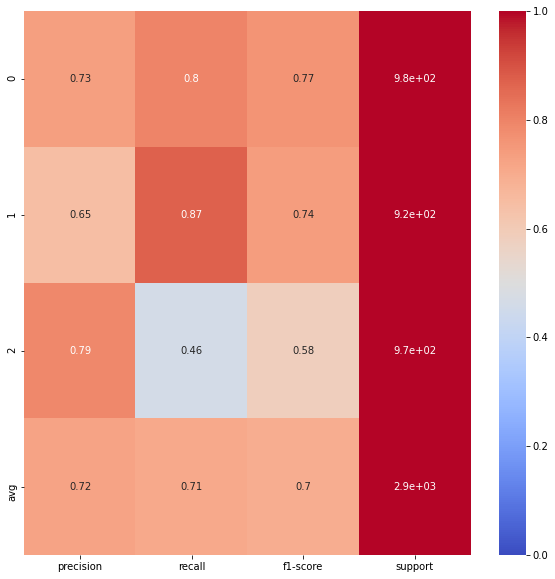

In [68]:
 from sklearn.naive_bayes import MultinomialNB

clfMNB = MultinomialNB()
clfMNB.fit(X_train_bal, y_train_bal)
predictions = clfMNB.predict(X_test_bal)


print("confusion matrix :"+str(CN(y_test_bal, predictions)))
print("accuracy :"+str(acc(y_test_bal, predictions)))
print("classification report :"+str(CR(y_test_bal, predictions)))
print("r2 score :"+str(r2(y_test_bal, predictions)))
plot_classification_report(y_test_bal, predictions)

In [69]:
predictionsMNB = clfMNB.predict_proba(X_test_bal)
print ("logloss: %0.3f " % multiclass_logloss(y_test_bal, predictionsMNB))
print(predictionsMNB.shape)
predictionsMNB

logloss: 0.704 
(2869, 3)


array([[0.02199323, 0.82693864, 0.15106813],
       [0.08621324, 0.82464074, 0.08914603],
       [0.38738667, 0.38100649, 0.23160684],
       ...,
       [0.39194492, 0.36937339, 0.23868169],
       [0.01233358, 0.03536199, 0.95230443],
       [0.27512009, 0.39364039, 0.33123952]])

###  [2] Support Vector Classifier

confusion matrix :[[970   0   8]
 [  0 891  27]
 [ 26  45 902]]
accuracy :0.9630533286859533
classification report :              precision    recall  f1-score   support

           0       0.97      0.99      0.98       978
           1       0.95      0.97      0.96       918
           2       0.96      0.93      0.94       973

    accuracy                           0.96      2869
   macro avg       0.96      0.96      0.96      2869
weighted avg       0.96      0.96      0.96      2869

r2 score :0.8933875299827027


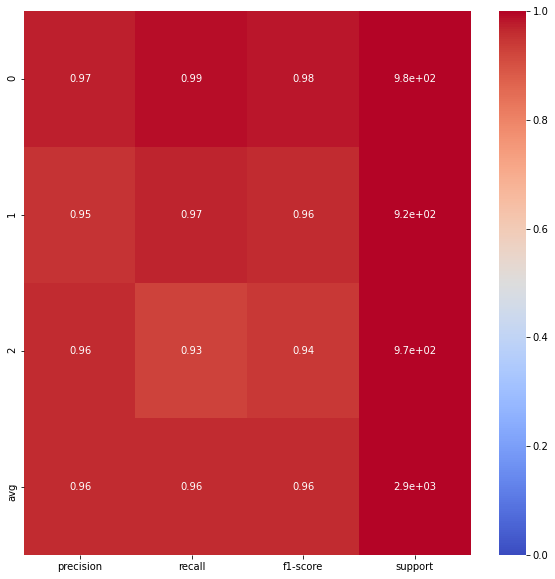

In [70]:
from sklearn.svm import SVC
# Fitting a simple SVM
clfSVC = SVC(C=1.0, probability=True) # since we need probabilities
clfSVC.fit(X_train_bal, y_train_bal)
predictions = clfSVC.predict(X_test_bal)

print("confusion matrix :"+str(CN(y_test_bal, predictions)))
print("accuracy :"+str(acc(y_test_bal, predictions)))
print("classification report :"+str(CR(y_test_bal, predictions)))
print("r2 score :"+str(r2(y_test_bal, predictions)))
plot_classification_report(y_test_bal, predictions)

In [71]:
predictionsSVC = clfSVC.predict_proba(X_test_bal)

print ("logloss: %0.3f " % multiclass_logloss(y_test_bal, predictionsSVC))
print(predictionsSVC.shape)
predictionsSVC

logloss: 0.103 
(2869, 3)


array([[1.38548264e-04, 9.86805703e-01, 1.30557491e-02],
       [1.46907220e-04, 9.86830303e-01, 1.30227895e-02],
       [9.95762393e-01, 7.52557187e-04, 3.48504973e-03],
       ...,
       [1.38925191e-04, 9.86792102e-01, 1.30689726e-02],
       [6.53629878e-06, 4.98207984e-06, 9.99988482e-01],
       [4.95279216e-03, 1.57173505e-02, 9.79329857e-01]])

### [2.1] Applying GRID SEARCH

In [72]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, train_size=0.2, random_state = 0)

    # TODO: Create a decision tree regressor object
    regressor = SVC()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scores = make_scorer(r2_score)


    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scores, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)


    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [73]:
import time
tic = time.time()
svc_model=fit_model(X_train_bal, y_train_bal)
tok = time.time()

print("time :"+str((tok-tic)*1000))

time :1302473.3905792236


In [75]:
print(svc_model)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


#### Applying Grid Searh results to SVC

In [76]:

svc_model.fit(X_train_bal, y_train_bal)
predictions = svc_model.predict(X_test_bal)

print("confusion matrix :"+str(CN(y_test_bal, predictions)))
print("accuracy :"+str(acc(y_test_bal, predictions)))
print("classification report :"+str(CR(y_test_bal, predictions)))
print("r2 score :"+str(r2(y_test_bal, predictions)))

confusion matrix :[[973   0   5]
 [  0 902  16]
 [ 20  36 917]]
accuracy :0.9731613802718717
classification report :              precision    recall  f1-score   support

           0       0.98      0.99      0.99       978
           1       0.96      0.98      0.97       918
           2       0.98      0.94      0.96       973

    accuracy                           0.97      2869
   macro avg       0.97      0.97      0.97      2869
weighted avg       0.97      0.97      0.97      2869

r2 score :0.922090887295052


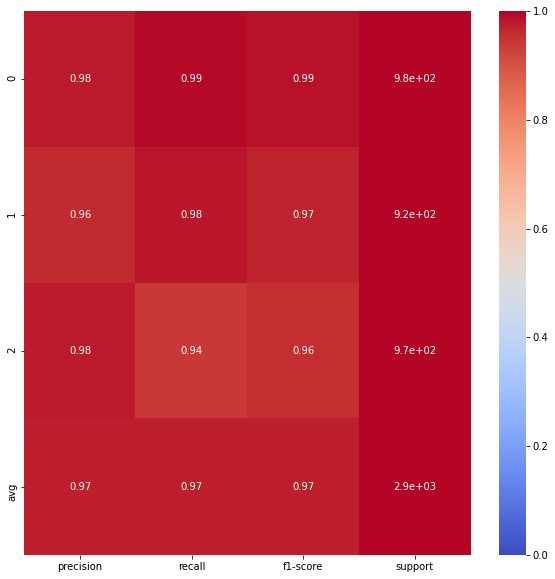

In [79]:
plot_classification_report(y_test_bal, predictions)